## Chapter 2-4, 2강 Computer Vision 전이학습(MobileNet/EfficientNet)으로 CIFAR-10 분류
- 데이터 다운로드 → 데이터 탐색 → 사전학습 백본 선택 → 학습/검증 → 시각화(정확도/손실) → 혼동행렬 → 오류 사례 분석


### 0. 환경 설정 및 라이브러리


In [1]:
# -------------------------------
# 환경 설정 및 공통 유틸
# - 라이브러리 import, 디바이스/시드 설정, 한글 폰트 지정
# - 재현성 확보와 시각화 환경 통일
# -------------------------------
# 필요한 라이브러리 임포트 (첫 강의 스타일 유지)
import os, time, random, numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

from sklearn.metrics import confusion_matrix, classification_report
import itertools

# -------------------------------
# 디바이스(CPU/GPU) 선택 및 시드 고정
# -------------------------------
# GPU가 있으면 'cuda', 없으면 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

# 시드 고정: 파이썬/넘파이/파이토치(및 CUDA) 모두 동일 시드 적용
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# -------------------------------
# 한글 폰트 설정 (그래프에서 한글 깨짐 방지)
# -------------------------------
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False


Device: cpu


### 1. 데이터 다운로드 및 DataLoader 설정


In [2]:
# -------------------------------
# 데이터 전처리 및 DataLoader 구성
# - CIFAR-10 다운로드, 학습/검증/테스트 분할, 변환/증강 설정
# - 전이학습 스케일(224)과 ImageNet 통계로 정규화 적용
# -------------------------------

# ImageNet 사전학습 모델의 입력 통계(평균/표준편차)
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std  = (0.229, 0.224, 0.225)

# -------------------------------
# 학습용 변환(증강 포함)
# - Resize(224x224): 사전학습 백본 입력 크기에 맞추기
# - RandomHorizontalFlip: 좌우반전으로 데이터 다양성 확보
# - Normalize: ImageNet 통계로 스케일 맞춤
# -------------------------------
train_tf = transforms.Compose([
    transforms.Resize((224,224)), # MobileNet/EfficientNet은 224×224 스케일에 맞춰 학습
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# -------------------------------
# 평가/테스트용 변환(증강 제외)
# - 학습 성능의 공정한 비교를 위해 결정적 변환만 적용
# -------------------------------
test_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

In [3]:
# -------------------------------
# 데이터셋 다운로드/로딩 (CIFAR-10)
# -------------------------------
root = './data'
train_full = datasets.CIFAR10(root=root, train=True, download=True, transform=train_tf)
test_full  = datasets.CIFAR10(root=root, train=False, download=True, transform=test_tf)
class_names = train_full.classes

# -------------------------------
# 학습/테스트 SUBSET 적용 (예: 10%만 사용)
# - 실습/데모 속도 향상을 위해 일부만 사용
# -------------------------------
SUBSET = 0.1  # 10% 사용
val_ratio = 0.2

In [ ]:
# -------------------------------
# 데이터 서브셋 분할 및 DataLoader 생성
# - train/val/test 분할, 배치/섞기 설정, 샘플 크기 출력
# - SUBSET로 전체에서 일정 비율만 추출해 실험 가속
# -------------------------------
# Train subset
full_len = len(train_full)
subset_len = int(full_len * SUBSET)
train_subset, _ = random_split(train_full, [subset_len, full_len - subset_len])

# subset에서 train/val 분할 (비율 유지)
val_len   = int(subset_len * val_ratio)
train_len = subset_len - val_len
train_set, val_set = random_split(train_subset, [train_len, val_len])

# Test subset
test_full_len = len(test_full)
test_subset_len = int(test_full_len * SUBSET)
# train_full 데이터를 SUBSET 비율만큼만 랜덤 추출
# - train_subset : 전체 데이터에서 SUBSET 비율만큼 무작위로 뽑은 부분집합
# - _            : 나머지 데이터 (여기서는 사용하지 않으므로 버림)
test_set, _ = random_split(test_full, [test_subset_len, test_full_len - test_subset_len])

# DataLoader 구성 (배치/섞기/num_workers 동일 스타일)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_set,   batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_set,  batch_size=32, shuffle=False, num_workers=2)

print('Train/Val/Test sizes:', len(train_set), len(val_set), len(test_set))
print('Sample image shape (C,H,W):', next(iter(train_loader))[0][0].shape)


Train/Val/Test sizes: 4000 1000 1000
Sample image shape (C,H,W): torch.Size([3, 224, 224])


### 2. 사전학습 백본 선택 (MobileNetV3 Small / EfficientNet-B0)


In [5]:
# -------------------------------
# 백본 선택 기본 설정
# - NUM_CLASSES: 분류 클래스 수(=CIFAR-10 → 10)
# - 기본 BACKBONE: 'mobilenet' 또는 'efficientnet' 중 초기값
#   (실제 모델 생성은 train_model 내부에서 수행)
# -------------------------------

NUM_CLASSES = 10
BACKBONE = 'mobilenet'  # 'mobilenet' | 'efficientnet'



### 3. 학습/검증 루프 (첫 강의와 동일 인터페이스)


In [ ]:
# -------------------------------
# 학습/검증 루프 및 모델 학습 함수
# - train_epoch / eval_epoch / train_model / 학습곡선 플롯
# -------------------------------

# -------------------------------
# 한 Epoch 동안 모델 학습(train) 수행
# -------------------------------
def train_epoch(model, loader, loss_fn, optim_):
    model.train()   # 학습 모드 (Dropout, BatchNorm 활성)
    tl = 0; tc = 0; n = 0   # tl: 총 손실, tc: 총 정답 수, n: 전체 샘플 수
    
    for x, y in loader:  # 배치 단위 데이터 로딩 from DataLoader
        x, y = x.to(device), y.to(device)    # GPU/CPU 장치에 데이터 올리기
        
        optim_.zero_grad()    # 이전 배치의 gradient 초기화
        out = model(x)        # 모델 forward pass → 예측 결과
        loss = loss_fn(out, y)  # 예측 vs 정답 비교 → 손실 계산
        
        loss.backward()       # 손실에 따른 gradient 계산 (역전파)
        optim_.step()         # optimizer가 파라미터 업데이트
        
        # 배치 손실/정확도 누적
        tl += loss.item() * x.size(0)                    # 배치 손실 * 배치 크기
        tc += (out.argmax(1) == y).sum().item()          # 예측 결과와 정답 비교 → 맞은 개수
        n  += x.size(0)                                  # 전체 샘플 수 카운트
    
    # 평균 손실, 평균 정확도 반환
    return tl/n, tc/n


# -------------------------------
# 한 Epoch 동안 모델 평가(eval) 수행
# -------------------------------
@torch.no_grad()   # 평가 시 gradient 계산 비활성화 → 메모리/연산 절약
def eval_epoch(model, loader, loss_fn):
    model.eval()   # 평가 모드 (Dropout, BatchNorm 비활성)
    tl = 0; tc = 0; n = 0
    
    for x, y in loader:  # 배치 단위 데이터 로딩 from DataLoader
        x, y = x.to(device), y.to(device)    # GPU/CPU 장치에 데이터 올리기
        
        out = model(x)        # 모델 forward pass
        loss = loss_fn(out, y)  # 손실 계산
        
        # 배치 손실/정확도 누적
        tl += loss.item() * x.size(0)
        tc += (out.argmax(1) == y).sum().item()
        n  += x.size(0)
    
    # 평균 손실, 평균 정확도 반환
    return tl/n, tc/n


# -------------------------------
# 학습/평가에 사용할 손실 함수 지정
# - CrossEntropyLoss: 다중 클래스 분류에서 일반적으로 사용하는 손실 함수
#   (softmax + NLLLoss가 결합된 형태)
# -------------------------------
criterion = nn.CrossEntropyLoss()


In [ ]:
# -------------------------------
# 모델 학습 함수 정의
# - train_model: 백본 생성/동결 옵션 포함, 학습 로그/히스토리 기록
# -------------------------------
def train_model(model=None, epochs=8, lr=1e-3, backbone=None, freeze_backbone=False):
    if model is None:
        chosen = backbone if backbone is not None else BACKBONE  # 지정 없으면 전역 BACKBONE 사용
        
        if chosen == 'mobilenet':
            weights = models.MobileNet_V3_Small_Weights.DEFAULT   # 사전 학습 가중치 불러오기
            base = models.mobilenet_v3_small(weights=weights)     # MobileNetV3 Small 로드
            in_features = base.classifier[-1].in_features         # 마지막 FC layer 입력 차원
            base.classifier[-1] = nn.Linear(in_features, NUM_CLASSES)  # 새로운 분류기(head)로 교체
        
        elif chosen == 'efficientnet':
            weights = models.EfficientNet_B0_Weights.DEFAULT      # 사전 학습 가중치 불러오기
            base = models.efficientnet_b0(weights=weights)        # EfficientNet-B0 로드
            in_features = base.classifier[-1].in_features         # 마지막 FC layer 입력 차원
            base.classifier[-1] = nn.Linear(in_features, NUM_CLASSES)  # 새로운 분류기(head)로 교체
        
        else:
            raise ValueError('backbone must be "mobilenet" or "efficientnet"')

        model = base.to(device)   # GPU/CPU 장치에 모델 올리기

        # --------------------------------------------
        # 백본 동결 (feature extractor로만 쓰고 분류기만 학습)
        # --------------------------------------------
        if freeze_backbone:
            for name, p in model.named_parameters():
                if 'classifier' not in name:   # classifier 파라미터는 학습 가능
                    p.requires_grad = False    # backbone 파라미터는 학습 불가

        # --------------------------------------------
        # 전역 상태 업데이트
        # - 이후 셀에서 동일 모델과 backbone 재사용 가능
        # --------------------------------------------
        globals()['model'] = model
        globals()['BACKBONE'] = chosen

        print('Selected backbone:', chosen)
        print('Trainable params:', sum(p.numel() for p in model.parameters() if p.requires_grad))


    optim_ = optim.Adam(model.parameters(), lr=lr)  # Adam optimizer
    hist = {
        'train_acc':[], 'val_acc':[], 
        'train_loss':[], 'val_loss':[]
    }   # 학습/검증 손실 및 정확도 기록용 딕셔너리

    for ep in range(1, epochs+1):
        # 1) 학습(train) 단계
        tr_l, tr_a = train_epoch(model, train_loader, criterion, optim_)
        # 2) 검증(validation) 단계
        va_l, va_a = eval_epoch(model, val_loader, criterion)
        
        # 3) 결과 기록
        hist['train_loss'].append(tr_l); hist['val_loss'].append(va_l)
        hist['train_acc'].append(tr_a);  hist['val_acc'].append(va_a)

        # 4) 진행 상황 출력
        print(f'[Ep {ep}/{epochs}] train={tr_a:.3f}/{tr_l:.3f}  val={va_a:.3f}/{va_l:.3f}')

    return hist


In [ ]:
# --------------------------------------------
# 학습 곡선 플로팅 함수
# - 입력: h (train/val의 loss & acc 기록을 담은 dict)
# - 동작: Accuracy 곡선, Loss 곡선을 각각 그려 시각화
# --------------------------------------------
def plot_hist(h, title):
    # ----------------------------
    # 1) 정확도(Accuracy) 시각화
    # ----------------------------
    plt.figure(figsize=(6,4))                    # 그래프 크기 설정
    plt.plot(h['train_acc'], label='train_acc')  # 학습 정확도 곡선
    plt.plot(h['val_acc'], label='val_acc')      # 검증 정확도 곡선
    plt.title(title+' (Accuracy)')               # 그래프 제목
    plt.legend()                                 # 범례 표시
    plt.tight_layout()                           # 여백 자동 조정
    plt.show()                                   # 그래프 출력

    # ----------------------------
    # 2) 손실(Loss) 시각화
    # ----------------------------
    plt.figure(figsize=(6,4))                    # 그래프 크기 설정
    plt.plot(h['train_loss'], label='train_loss')# 학습 손실 곡선
    plt.plot(h['val_loss'], label='val_loss')    # 검증 손실 곡선
    plt.title(title+' (Loss)')                   # 그래프 제목
    plt.legend()                                 # 범례 표시
    plt.tight_layout()                           # 여백 자동 조정
    plt.show()                                   # 그래프 출력



### 4. 학습 실행


In [9]:
# -------------------------------
# 학습 실행 진입점
# - train_model 호출, 백본/하이퍼파라미터 선택
# -------------------------------
print('TRAIN_start')
hist = train_model(backbone='mobilenet', epochs=1, lr=1e-3)  # 'mobilenet' | 'efficientnet'
print('TRAIN_end')


TRAIN_start
Selected backbone: mobilenet
Trainable params: 1528106
[Ep 1/1] train=0.718/0.811  val=0.777/0.723
TRAIN_end


### 5. 학습 곡선(정확도/손실) 시각화


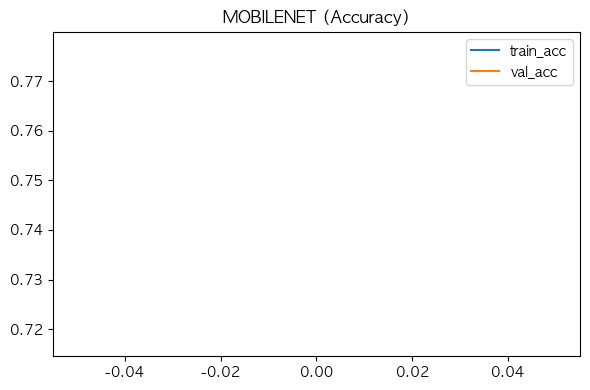

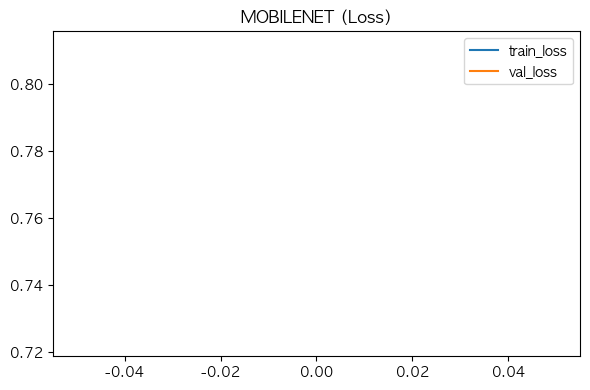

In [10]:
# -------------------------------
# 학습 곡선 시각화
# - 정확도/손실 곡선 플롯
# -------------------------------
plot_hist(hist, f'{BACKBONE.upper()} ' )


### 6. 오분류 분석 (혼동행렬, Top-3 혼동 쌍, 사례 시각화)


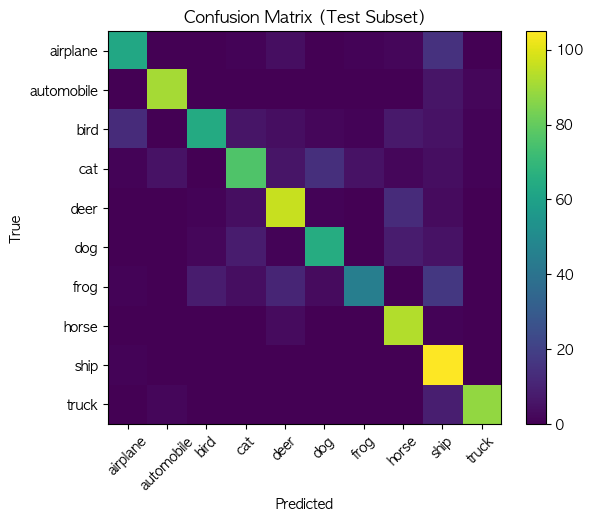

In [ ]:
# -------------------------------
# 혼동행렬 및 오분류 분석 (1)
# - 예측 결과 수집 → 혼동행렬(confusion matrix) 계산 및 시각화
# -------------------------------

# 원본 테스트셋 (subset 아님, 오리지널 전체 CIFAR-10 테스트셋)
# 이미지를 직접 확인할 때 사용 (transform은 ToTensor만 적용)
raw_test = datasets.CIFAR10(
    root='./data', train=False, download=False, transform=transforms.ToTensor()
)

# test_set이 Subset이면 indices 속성으로 원본 인덱스를 가져옴
# Subset이 아니면 그냥 [0 ~ len(raw_test)) 범위 사용
subset_to_full_idx = (
    np.array(test_set.indices) if hasattr(test_set, 'indices') 
    else np.arange(len(raw_test))
)

# --------------------------------------------
# 모델의 전체 예측 및 라벨 수집 함수
# - DataLoader를 순회하며 y(정답), ŷ(예측)를 모두 numpy 배열로 반환
# --------------------------------------------
@torch.no_grad()   # 평가 시 gradient 계산 불필요 → 속도/메모리 절약
def get_all_preds_with_subset(model, subset_loader):
    model.eval()       # 평가 모드
    ys = []            # 실제 정답(label) 모음
    ps = []            # 모델 예측(pred) 모음
    for x, y in subset_loader:
        x = x.to(device)               # 입력 배치 장치로 이동
        out = model(x)                 # 모델 forward pass
        ps.append(out.argmax(1).cpu().numpy())  # 예측 라벨 저장
        ys.append(y.numpy())                       # 실제 라벨 저장
    return np.concatenate(ys), np.concatenate(ps)  # 전체 합치기

# --------------------------------------------
# 혼동행렬 계산
# --------------------------------------------
y_true, y_pred = get_all_preds_with_subset(model, test_loader)   # 정답 vs 예측
cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))

# --------------------------------------------
# 혼동행렬 시각화
# --------------------------------------------
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')   # 2D 행렬 이미지 출력
plt.title('Confusion Matrix (Test Subset)')
plt.colorbar()                            # 색상 막대 표시
plt.xticks(range(NUM_CLASSES), class_names, rotation=45)  # x축: 예측 클래스
plt.yticks(range(NUM_CLASSES), class_names)               # y축: 실제 클래스
plt.tight_layout()
plt.xlabel('Predicted')   # 열: 예측
plt.ylabel('True')        # 행: 실제
plt.show()


In [ ]:
# -------------------------------
# 혼동행렬 및 오분류 분석 (2)
# - 혼동행렬(cm)을 바탕으로 가장 많이 헷갈린 클래스 쌍 Top-3 추출
# -------------------------------

pairs = []   # (클래스 쌍, 혼동 횟수) 저장용 리스트

# 모든 클래스 쌍 (i: 실제 클래스, j: 예측 클래스) 순회
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        if i != j and cm[i, j] > 0:   # 자기 자신(i==j)은 제외, 혼동이 발생한 경우만
            pairs.append(((i, j), cm[i, j]))  # ((실제, 예측), 혼동횟수) 저장

# 혼동 횟수 기준으로 내림차순 정렬 → 상위 3개 선택
pairs = sorted(pairs, key=lambda x: x[1], reverse=True)[:3]

# 사람이 보기 좋게 클래스 이름으로 변환하여 출력
print('Top-3 혼동 클래스 쌍:', [
    (class_names[i], class_names[j], n) for (i, j), n in pairs
])



Top-3 혼동 클래스 쌍: [('frog', 'ship', 17), ('airplane', 'ship', 15), ('cat', 'dog', 14)]


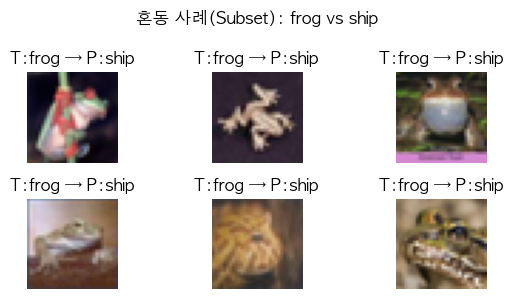

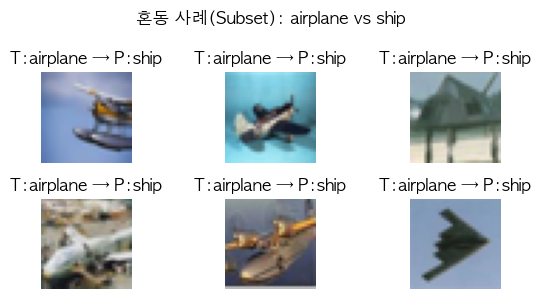

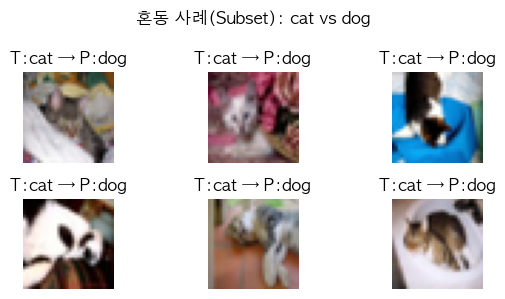

In [ ]:
# -------------------------------
# 혼동행렬 및 오분류 분석 (3)
# - 혼동 사례 인덱스 탐색 및 시각화
# -------------------------------

# 특정 (실제 라벨, 예측 라벨) 쌍에 해당하는 오분류 사례의 원본 인덱스 추출
def find_mismatch_indices_subset(true_label, pred_label, max_show=6):
    out_idx = []   # 오분류된 샘플들의 원본 인덱스 저장
    count = 0      # 현재까지 찾은 개수
    ptr = 0        # subset 내 전체 진행된 데이터 개수 (global index 계산용)

    # test_set을 DataLoader로 순회 (batch 단위 예측)
    for batch_x, batch_y in DL(test_set, batch_size=128, shuffle=False):
        logits = model(batch_x.to(device))                # 모델 예측(logits)
        preds = logits.argmax(1).cpu().numpy()            # 예측 라벨
        for k in range(len(batch_y)):                     # 배치 내 개별 샘플 확인
            if batch_y[k].item() == true_label and preds[k] == pred_label:
                # subset 인덱스(ptr + k)를 full 인덱스로 변환
                full_idx = subset_to_full_idx[ptr + k]
                out_idx.append(full_idx)
                count += 1
                if count >= max_show:                     # max_show 개수만큼 찾으면 종료
                    return out_idx
        ptr += len(batch_y)                               # 진행된 샘플 개수 업데이트

    return out_idx   # 찾은 인덱스 리스트 반환

# --------------------------------------------
# Top-3 혼동 클래스 쌍(pairs)별 실제 이미지 시각화
# --------------------------------------------
for (i, j), _ in pairs:   # (실제 라벨, 잘못 예측된 라벨)
    ids_full = find_mismatch_indices_subset(i, j, max_show=6)
    if not ids_full:       # 혼동 사례가 없으면 건너뜀
        continue

    plt.figure(figsize=(6,3))
    for k, idx in enumerate(ids_full):
        img, _ = raw_test[idx]                    # 원본 CIFAR-10 이미지 로드
        plt.subplot(2, 3, k+1)                    # 2행 3열 subplot에 배치
        plt.imshow(img.permute(1,2,0))            # (C,H,W) → (H,W,C) 변환 후 출력
        plt.axis('off')
        plt.title(f'T:{class_names[i]} → P:{class_names[j]}')  # 실제 vs 예측 표시
    
    plt.suptitle(f'혼동 사례(Subset): {class_names[i]} vs {class_names[j]}')  # 전체 제목
    plt.tight_layout()
    plt.show()